# Implementation of CoFi for marine traffic modeling

This notebook showcases how to use Consititional Filters (CoFi) in ProMis to improve modeling of ship movements.

## Setup

In [1]:
# This will auto-relead changed ProMis imports
%reload_ext autoreload
%autoreload 2

In [2]:
# We need some additional packages
!pip install -q svgpath2mpl svgpathtools filterpy keplergl

In [62]:
# Standard library
import json
from copy import copy
from math import ceil, isfinite
from pathlib import Path
from time import monotonic
from typing import Any

# Math
import numpy as np
from numpy import array, deg2rad, eye, mean, ndarray, pi, set_printoptions, stack
from numpy.random import seed, standard_normal
from scipy.stats import norm, uniform

# Data Handling
import pandas as pd
from filterpy.monte_carlo import systematic_resample

# Plotting
import matplotlib
from keplergl import KeplerGl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.transforms import Affine2D
from seaborn import move_legend
from svgpath2mpl import parse_path
from svgpathtools import svg2paths
import seaborn as sns

# ProMis
from promis import ProMis, StaRMap
from promis.geo import (
    CartesianCollection,
    CartesianMap,
    CartesianRasterBand,
    PolarCollection,
    PolarLocation,
)
from promis.loaders import NauticalChartLoader
from promis.logic.spatial import Depth


In [4]:
# Use full width of juptyer notebook
set_printoptions(linewidth=180, formatter={"float_kind": "{:4.6f}".format})

# Make plots look nice in a paper
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

sns.set_theme(style="ticks", rc={"figure.figsize": (8, 3), "legend.title_fontsize": 15})
sns.set_style({"font.family": "serif", "font.serif": "Times New Roman"})

## Define the setting

In [5]:
# The format of the bbox is:
# (lat, lon) lower left, and then
# (lat, lon) upper right

setting = "New York Harbor"
bbox = (
    (40.52, -74.08),
    (40.70, -73.85),
)

# setting = "Port of Charleston, South Carolina"
# bbox = (
#     (32.75, -79.97),
#     (32.875, -79.87),
# )

# setting = "Baltimore"
# bbox = (
#     (39.174, -76.6304993),
#     (39.29, -76.4495423),
# )

# setting = "Port of Virginia (Norfolk)"
# bbox = (
#     (36.7711453, -76.4994133),
#     (37.3020172, -75.8786833),
# )

In [6]:
output_folder = Path(".") / "cofi-exports" / setting
output_folder.mkdir(exist_ok=True, parents=True)

In [7]:
origin = PolarLocation(
    latitude=mean([bbox[0][0], bbox[1][0]]), longitude=mean([bbox[0][1], bbox[1][1]])
)
width = PolarLocation(latitude=bbox[0][0], longitude=bbox[0][1]).distance(
    PolarLocation(latitude=bbox[0][0], longitude=bbox[1][1])
)
height = PolarLocation(latitude=bbox[0][0], longitude=bbox[0][1]).distance(
    PolarLocation(latitude=bbox[1][0], longitude=bbox[0][1])
)
dimensions = width, height
dimensions

(19490.788929051603, 19988.34793513066)

In [8]:
target_resolution = (200, 200)
support_resolution = (100, 100)

## Load the nautical chart data

Like all somewhat time-consuming steps, this only needs to be done once.

In [9]:
uam_path = Path("nautical_chart_uam.pkl")

if uam_path.exists():
    uam = CartesianMap.load(uam_path)

else:
    loader = NauticalChartLoader(
        chart_root=Path(".").absolute().parent / "data" / "us_charts-ny",
        origin=origin,
        dimensions=dimensions,
    )
    loader.load(n_jobs=16)

    uam = loader.to_cartesian_map()
    uam.apply_covariance(50.0 * eye(2))

    uam.save(uam_path)

print(f"Loaded {len(uam.features)} features")

Loaded 3802 features


In [10]:
# Print the some features
for feature in uam.features[500:1000:31]:  # Get some diversity
    print(f"{type(feature).__name__} - {feature.location_type}: \t{feature.name}")

CartesianPolygon - anchorage: 	US5NYCCF#0226118FBFB01C82 (Anchor berth (single)): "G3"
CartesianPolygon - anchorage: 	US5NYCCF#022602C159BB1C82 (Anchor berth (single)): "O5"
CartesianPolygon - anchorage: 	US5NYCCF#022622152D461C82 (Anchor berth (single)): "K10"
CartesianPolygon - anchorage: 	US5NYCCF#022608F3C61E1C82 (Anchor berth (single)): "N6"
CartesianPolygon - anchorage: 	US5NYCCF#0226242A0CDD1C82 (Anchor berth (single)): "I6"
CartesianPolygon - anchorage: 	US5NYCCF#02260B6F82FB1C82 (Anchor berth (single)): "N8"
CartesianPolygon - anchorage: 	US5NYCCF#022639479B711C82 (Anchor berth (single)): "E5"
CartesianPolygon - anchorage: 	US5NYCCF#02263ABB47F41C82 (Anchor berth (single)): "M5"
CartesianPolygon - anchorage: 	US5NYCCF#02261DC124E61C82 (Anchor berth (single)): "F4"
CartesianPolygon - anchorage: 	US5NYCCF#02262DB2D5AE1C82 (Anchor berth (single)): "C9"
CartesianPolygon - anchorage: 	US5NYCCF#022605EDE0241C82 (Anchor berth (single)): "P2"
CartesianPolygon - anchorage: 	US5NYCCF#02

## Prepare the mission landscape

In [11]:
logic_specifics_dummy = r"""
% Perception from sensors
draught ~ normal(3, 0.5).
0.1::anchoring.
0.9::travels_waterways.
"""

logic = r"""
% Background knowledge
sufficient_depth(X) :-
    A is depth(X, water), B is draught,
    A + B < -1.5, \+ over(X, land).

0.95::safe(X) :-
    sufficient_depth(X), distance(X, land) > 50.

proper_anchorage(X) :-
    anchoring, over(X, anchorage);
    \+ anchoring, \+ over(X, anchorage).

0.90::waterway_preference(X) :-
    travels_waterways, distance(X, waterway) < 400;
    \+ travels_waterways.

% Compliance with Constitution
landscape(X) :-
    proper_anchorage(X), safe(X),
    waterway_preference(X).
"""

support = CartesianRasterBand(origin, support_resolution, width, height)
target = CartesianRasterBand(origin, target_resolution, width, height)

In [12]:
starmap_path = Path("maritime_star_map.pkl")

if starmap_path.exists():
    star_map = StaRMap.load(starmap_path)

else:
    # We create a statistical relational map (StaR Map) to represent the
    # stochastic relationships in the environment, computing a raster of 100 x 100 points
    # using linear interpolation of a sample set
    before = monotonic()
    star_map = StaRMap(target, uam, method="nearest")

    star_map.initialize(
        # The sample points for which the relations will be computed directly
        support=support,
        # We now compute the Distance and Over relationships for the selected points
        # For this, we take many random samples from generated/possible map variations
        number_of_random_maps=5,  # TODO
        # The logic used later. This is required to determine which relationships to prepare
        logic=logic + logic_specifics_dummy,
    )
    after = monotonic()

    star_map.save(starmap_path)

    runtime = after - before
    f"Computed StaR Map in {runtime} seconds"


### Visualize the relations

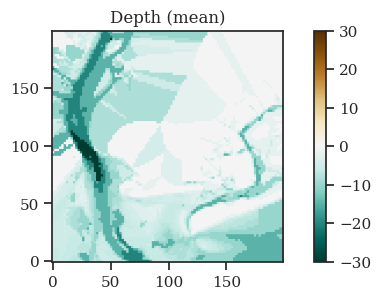

<Figure size 800x300 with 0 Axes>

In [13]:
# We first plot the depth since we have some special handling for it
depth: Depth = star_map.get("depth", "water")
plt.title("Depth (mean)")
depth.plot(value_index=0)
plt.show()
plt.clf()

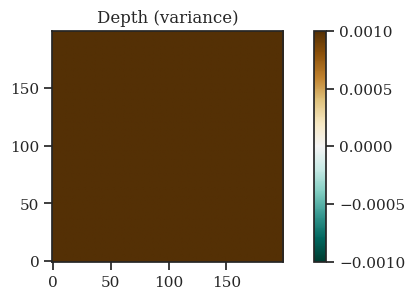

<Figure size 800x300 with 0 Axes>

In [14]:
plt.title("Depth (variance)")
depth.plot(value_index=1)
plt.show()
plt.clf()

In [15]:
all_relations = star_map.relation_and_location_types
all_relations

{'over': {'anchorage', 'land'},
 'distance': {'land', 'waterway'},
 'depth': {'water'}}

Lowered zoom level to keep map size reasonable. (z = 12)
Lowered zoom level to keep map size reasonable. (z = 12)
Lowered zoom level to keep map size reasonable. (z = 12)
Lowered zoom level to keep map size reasonable. (z = 12)
Lowered zoom level to keep map size reasonable. (z = 12)


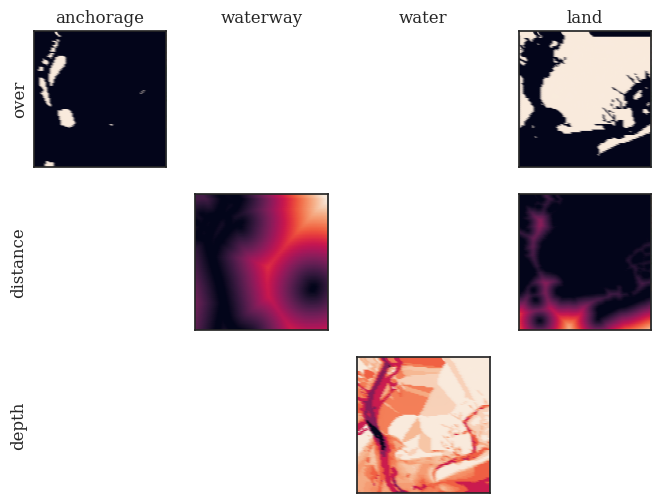

<Figure size 800x300 with 0 Axes>

In [16]:
# Create one row per relation type and one column per location type
fig, axes = plt.subplots(
    len(all_relations), len(star_map.location_types), figsize=(8, 6), sharex=True, sharey=True
)

for i, (relation_type, location_types) in enumerate(all_relations.items()):
    for j, location_type in enumerate(star_map.location_types):
        # Get the axis for the current row and column
        ax = axes[i, j]

        # Label the rows and columns
        if j == 0:
            ax.set_ylabel(relation_type)
        if i == 0:
            ax.set_title(location_type)

        # Get the relation and visualize it
        if location_type in location_types:
            relation = star_map.get(relation_type, location_type)
            relation.parameters.scatter(ax=ax, alpha=0.5, value_index=0)
        else:
            # No data available, but we still want to show the label
            ax.set_xticks([])
            ax.set_yticks([])
            # Despine
            sns.despine(ax=ax, left=True, bottom=True, right=True, top=True)

        # if j == len(all_location_types) - 1:
        #     plt.colorbar()

plt.show()
plt.clf()

Lowered zoom level to keep map size reasonable. (z = 12)


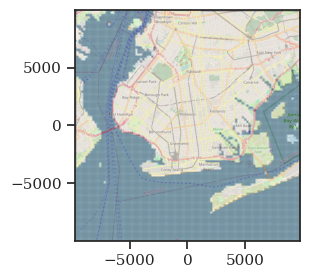

<Figure size 800x300 with 0 Axes>

In [17]:
relation = star_map.get("over", "land")
relation.parameters.scatter(vmin=0, s=0.1, alpha=0.2)
plt.show()
plt.clf()

In [18]:
folder = output_folder / "relations"
folder.mkdir(exist_ok=True)

for relation_type, location_types in star_map.relation_and_location_types.items():
    for location_type in location_types:
        relation = star_map.get(relation_type, location_type)
        path = folder / f"{relation_type}_{location_type}.csv"
        relation.parameters.to_polar().to_csv(path)

### Run some inference

To make sure everything will run smoothly, we can run some inference on the data.

In [19]:
# In ProMis, we define the constraints of the mission
# as hybrid probabilistic first-order logic programs

# Solve mission constraints using StaRMap parameters and multiprocessing
promis = ProMis(star_map)


% Background knowledge
sufficient_depth(X) :-
    A is depth(X, water), B is draught,
    A + B < -1.5, \+ over(X, land).

0.95::safe(X) :-
    sufficient_depth(X), distance(X, land) > 50.

proper_anchorage(X) :-
    anchoring, over(X, anchorage);
    \+ anchoring, \+ over(X, anchorage).

0.90::waterway_preference(X) :-
    travels_waterways, distance(X, waterway) < 400;
    \+ travels_waterways.

% Compliance with Constitution
landscape(X) :-
    proper_anchorage(X), safe(X),
    waterway_preference(X).

% Perception from sensors
draught ~ normal(3, 0.5).
0.1::anchoring.
0.9::travels_waterways.

distance(x_0, waterway) ~ normal(3062.361577277537, 0.001).
distance(x_0, land) ~ normal(3731.38903012275, 0.001).
depth(x_0, water) ~ normal(-6.0, 0.001).
0.0::over(x_0, anchorage).
0.0::over(x_0, land).
query(landscape(x_0)).
distance(x_1, waterway) ~ normal(2865.4850686239174, 0.001).
distance(x_1, land) ~ normal(3566.6827659221826, 0.001).
depth(x_1, water) ~ normal(-6.0, 0.001).
0.0::ove

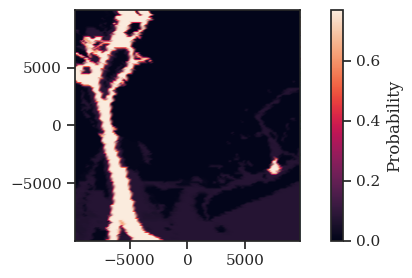

<Figure size 800x300 with 0 Axes>

In [20]:
# Solve an example logic program
landscape = promis.solve(
    support, logic + logic_specifics_dummy, n_jobs=16, batch_size=3, print_first=True
)

# Show the resulting landscape
ax = landscape.scatter()
plt.colorbar(ax, label="Probability")
plt.show()
plt.clf()

## Load some AIS data

The Automatic Identification System (AIS) is a system used for tracking ships. We will use its observations as our measurements and for model validation.

In [21]:
vessel_types = json.loads((Path("..") / "data" / "vessel_types_simplified.json").read_text())
# vessel_types

In [22]:
def load_ais(
    path: str | Path, bbox: None | tuple[tuple[float, float], tuple[float, float]]
) -> pd.DataFrame:
    # Read the csv into pandas
    df = pd.read_csv(path)

    # Filter by bounding box
    if bbox is not None:
        # This is a overly simplistic bounding box filter that only works on moderate latitudes
        # and far from the dateline
        df = df[
            (df["LAT"] > bbox[0][0])
            & (df["LAT"] < bbox[1][0])
            & (df["LON"] > bbox[0][1])
            & (df["LON"] < bbox[1][1])
        ]

    # Sort by time per ship
    df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])
    df.sort_values(["MMSI", "BaseDateTime"], inplace=True)

    df.loc[df["VesselType"].isna(), "VesselType"] = 0  # Zero means unknown

    df["VesselType"] = df["VesselType"].astype(int)
    df["VesselTypeName"] = df["VesselType"].astype(str).map(vessel_types)

    df["is_anchoring"] = df["Status"] == 1

    # Filter out all vessels that have an average SOG of less than 1 knot
    df = df.groupby("MMSI").filter(lambda x: x["SOG"].mean() > 1)

    return df


df = pd.concat(
    [
        load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_01.csv", bbox=bbox),
        # load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_02.csv", bbox=bbox),
        # load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_03.csv", bbox=bbox),
    ]
)
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName,is_anchoring
9007215,232040168,2023-08-01 19:06:21,40.52027,-74.03197,8.7,339.7,344.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False
6671099,232040168,2023-08-01 19:07:49,40.52332,-74.03350,7.9,336.6,345.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False
9009252,232040168,2023-08-01 19:09:19,40.52637,-74.03515,7.9,340.2,349.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False
6685546,232040168,2023-08-01 19:10:21,40.52848,-74.03587,8.7,353.3,356.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False
6697396,232040168,2023-08-01 19:12:25,40.53272,-74.03660,5.5,344.6,357.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899297,636092711,2023-08-01 05:35:27,40.53780,-74.02317,17.3,156.9,155.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,False
1892555,636092711,2023-08-01 05:36:33,40.53303,-74.02010,17.2,151.1,144.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,False
1906669,636092711,2023-08-01 05:37:39,40.52898,-74.01588,16.9,138.2,132.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,False
1895628,636092711,2023-08-01 05:38:45,40.52550,-74.01085,17.0,129.9,124.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,False


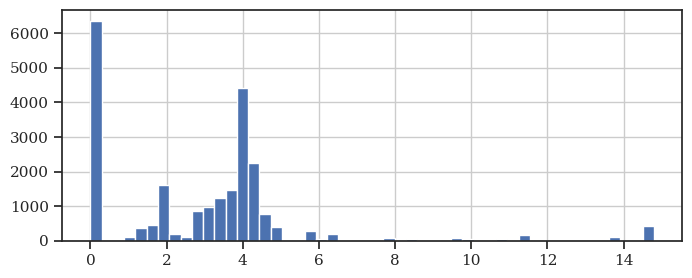

In [23]:
df["Draft"].hist(bins=50)
pass

In [24]:
df["Status"].value_counts().sort_index()

Status
0.0     31495
1.0       924
5.0      3583
6.0       206
7.0        82
8.0       169
11.0       45
12.0     2678
15.0     1943
Name: count, dtype: int64

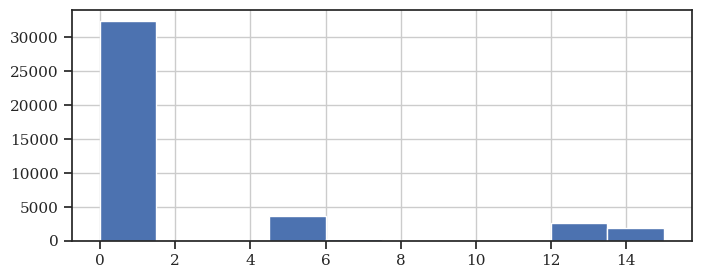

In [25]:
df["Status"].hist()
pass

In [26]:
collection = PolarCollection(origin=origin, number_of_values=0)
collection.append_with_default(df[["LON", "LAT"]].values, value=())
cartesian = collection.to_cartesian()

df.loc[:, "East"] = cartesian.data["east"].values
df.loc[:, "North"] = cartesian.data["north"].values
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,...,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName,is_anchoring,East,North
9007215,232040168,2023-08-01 19:06:21,40.52027,-74.03197,8.7,339.7,344.0,DANCING BEAR,IMO0000000,MKTD4,...,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False,-5675.188325,-9961.958870
6671099,232040168,2023-08-01 19:07:49,40.52332,-74.03350,7.9,336.6,345.0,DANCING BEAR,IMO0000000,MKTD4,...,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False,-5804.580884,-9623.172981
9009252,232040168,2023-08-01 19:09:19,40.52637,-74.03515,7.9,340.2,349.0,DANCING BEAR,IMO0000000,MKTD4,...,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False,-5944.129822,-9284.376577
6685546,232040168,2023-08-01 19:10:21,40.52848,-74.03587,8.7,353.3,356.0,DANCING BEAR,IMO0000000,MKTD4,...,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False,-6004.950390,-9050.023266
6697396,232040168,2023-08-01 19:12:25,40.53272,-74.03660,5.5,344.6,357.0,DANCING BEAR,IMO0000000,MKTD4,...,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False,-6066.422330,-8579.143087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899297,636092711,2023-08-01 05:35:27,40.53780,-74.02317,17.3,156.9,155.0,SEATRADE RED,IMO9690107,D5LR9,...,0.0,185.0,NaN,NaN,79.0,A,Cargo,False,-4928.172225,-8015.872204
1892555,636092711,2023-08-01 05:36:33,40.53303,-74.02010,17.2,151.1,144.0,SEATRADE RED,IMO9690107,D5LR9,...,0.0,185.0,NaN,NaN,79.0,A,Cargo,False,-4668.412352,-8545.723697
1906669,636092711,2023-08-01 05:37:39,40.52898,-74.01588,16.9,138.2,132.0,SEATRADE RED,IMO9690107,D5LR9,...,0.0,185.0,NaN,NaN,79.0,A,Cargo,False,-4311.127405,-8995.670285
1895628,636092711,2023-08-01 05:38:45,40.52550,-74.01085,17.0,129.9,124.0,SEATRADE RED,IMO9690107,D5LR9,...,0.0,185.0,NaN,NaN,79.0,A,Cargo,False,-3885.130010,-9382.339931


### Visualize it

In [27]:
MMSIs = df["MMSI"].value_counts()
min_observations = 10 + 20 + 15  # warmup + some usage in between + dead_reckoning
relevant_MMSIs = MMSIs[MMSIs > min_observations].index
df = df[df["MMSI"].isin(relevant_MMSIs)].copy()

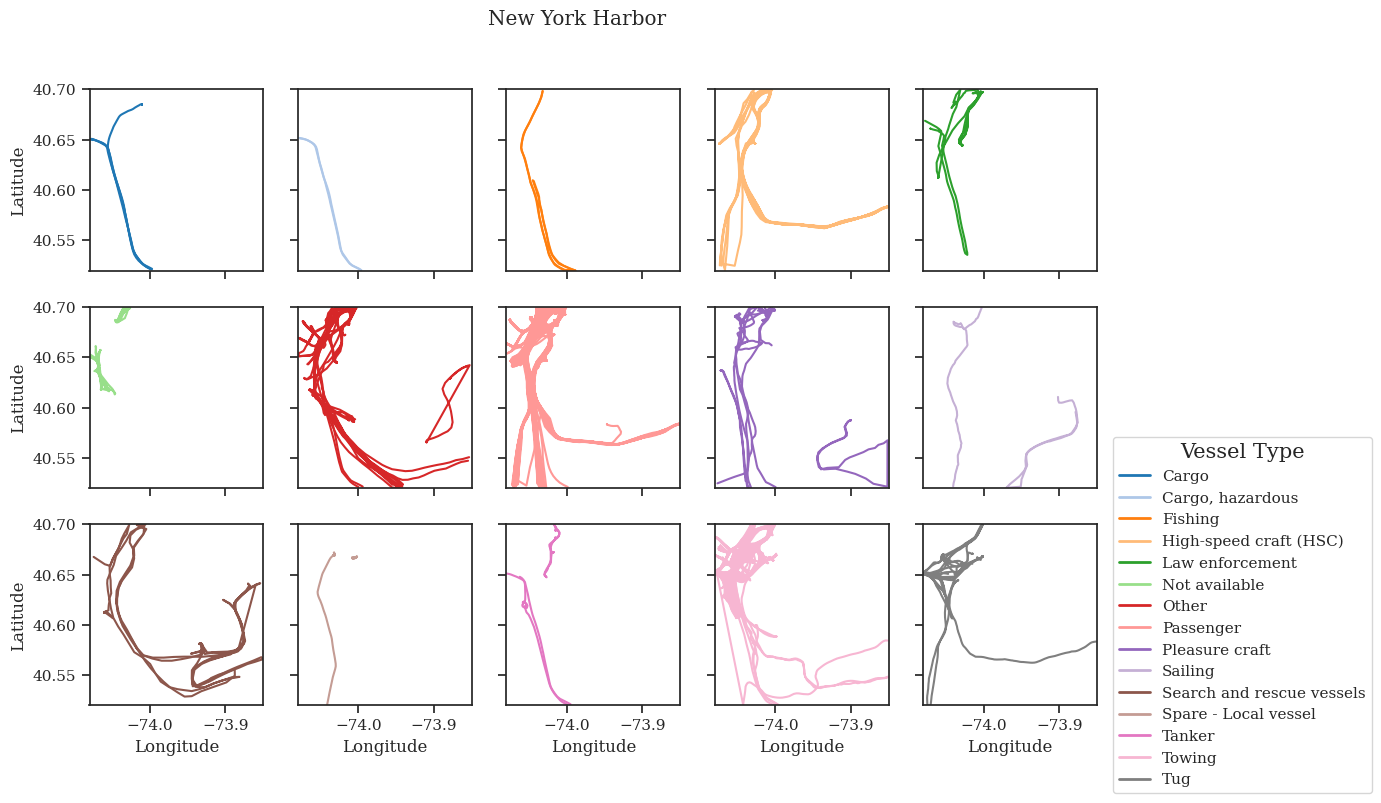

<Figure size 800x300 with 0 Axes>

In [28]:
vessel_type_to_index = {
    vessel_type: i for i, vessel_type in enumerate(sorted(df["VesselTypeName"].unique()))
}
palette = sns.color_palette("tab20", len(vessel_type_to_index))

all_vessel_types = df["VesselTypeName"].unique()

cols = 5
all_rows = ceil(len(all_vessel_types) / cols)
fig, ax = plt.subplots(ncols=cols, nrows=all_rows, figsize=(13, 8), sharex=True, sharey=True)

for (vessel_type, i), ax in zip(vessel_type_to_index.items(), ax.flatten()):
    for mmsi in relevant_MMSIs:
        df_ = df[df["MMSI"] == mmsi]
        if all_vessel_types is not None and df_["VesselTypeName"].iloc[0] != vessel_type:
            continue
        vessel_type = df_["VesselTypeName"].iloc[0]
        color = palette[vessel_type_to_index[vessel_type]]
        ax.plot(df_["LON"], df_["LAT"], c=color)

    ax.set_xlim(bbox[0][1], bbox[1][1])
    if i >= cols * (all_rows - 1):
        ax.set_xlabel("Longitude")
    ax.set_ylim(bbox[0][0], bbox[1][0])
    if i % cols == 0:
        ax.set_ylabel("Latitude")

    col = i % cols
    row = i // cols
    # if we are in the center, right-hand side
    if col == cols - 1 and row == len(all_vessel_types) // cols - 1:
        ax.legend(
            [
                plt.Line2D([0], [0], color=palette[i], lw=2, label=vessel_type)
                for i, vessel_type in enumerate(vessel_type_to_index)
            ],
            vessel_type_to_index.keys(),
            title="Vessel Type",
            loc="center left",
            bbox_to_anchor=(1.05, 0.5),
        )

plt.suptitle(setting)

plt.savefig(output_folder / "ais-all-tracks.pdf", bbox_inches="tight")

plt.show()
plt.clf()

In [29]:
relevant_vessel_types = [
    "Cargo",
    "Cargo, hazardous",
    "Search and rescue vessels",
    "Towing",
    "Other",
    "Tanker",
    "Tanker, hazardous",
]

In [30]:
for mmsi in relevant_MMSIs:
    df_ = df[df["MMSI"] == mmsi]
    if df_["VesselTypeName"].iloc[0] not in relevant_vessel_types:
        continue

    plt.plot(df_["LON"], df_["LAT"], c=color)
    plt.xlim(bbox[0][1], bbox[1][1])
    plt.ylim(bbox[0][0], bbox[1][0])
    plt.gca().set_aspect("equal")

    path = output_folder / "plot-individual-traces" / df_["VesselTypeName"].iloc[0]
    path.mkdir(exist_ok=True, parents=True)
    plt.savefig(path / f"{mmsi}.pdf", bbox_inches="tight")
    plt.clf()

<Figure size 800x300 with 0 Axes>

In [31]:
# An example of a single vessel
track_mmsi = 636017103
track_mmsi

636017103

In [32]:
df_ = df[df["MMSI"] == track_mmsi]
df_

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,...,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName,is_anchoring,East,North
8684223,636017103,2023-08-01 12:42:33,40.52173,-73.99979,14.1,297.4,297.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-2948.118757,-9801.407044
4277332,636017103,2023-08-01 12:43:39,40.52370,-74.00477,14.0,297.5,299.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-3370.027333,-9582.470582
4289181,636017103,2023-08-01 12:44:45,40.52617,-74.00927,13.7,313.2,317.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-3751.210309,-9308.008359
4296179,636017103,2023-08-01 12:45:52,40.52931,-74.01278,13.5,322.8,323.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-4048.440577,-8959.172452
4301282,636017103,2023-08-01 12:46:58,40.53263,-74.01607,13.6,323.1,323.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-4326.991573,-8590.347249
4307443,636017103,2023-08-01 12:47:59,40.53573,-74.01908,13.7,324.8,326.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-4581.807728,-8245.955907
4319559,636017103,2023-08-01 12:49:09,40.53969,-74.02179,13.6,339.8,342.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-4811.123179,-7806.073364
4327723,636017103,2023-08-01 12:50:19,40.54401,-74.02339,13.7,346.0,347.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-4946.353875,-7326.270097
4376598,636017103,2023-08-01 12:51:29,40.54825,-74.02470,13.3,346.7,347.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-5057.008143,-6855.364301
4337261,636017103,2023-08-01 12:52:39,40.55244,-74.02601,13.0,347.2,347.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-5167.652230,-6390.008770


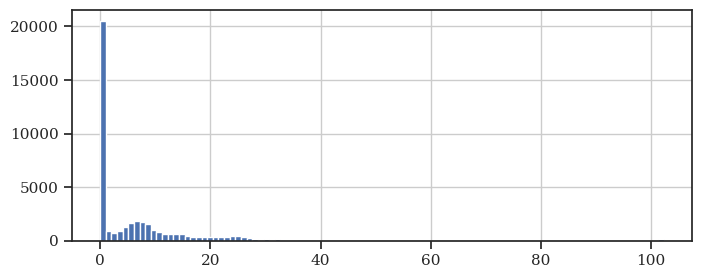

In [33]:
df["SOG"].hist(bins=100)
pass

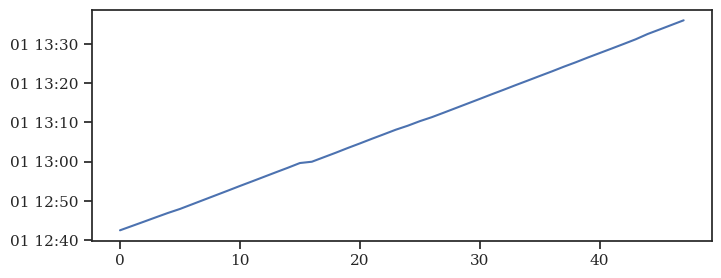

In [34]:
plt.plot(np.arange(len(df_["BaseDateTime"])), df_["BaseDateTime"])
pass

### Provide the trust features to the system

- We can read the categorical AIS class directly from the data.
- We compute the binary `travels_waterways` from a simple heuristic.
- We estimate the continous `anchoring` probability using a machine learning model estimated on a hold-out set of data. 

In [35]:
df["travels_waterways"] = df["VesselTypeName"].isin(
    ["Tanker", "Tanker, hazardous", "Cargo", "Cargo, hazardous"]
) & (df["Length"] >= 50)

df["travels_waterways"].value_counts(dropna=False, normalize=True)

travels_waterways
False    0.978783
True     0.021217
Name: proportion, dtype: float64

In [36]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, RobustScaler

anchoring_reg = MLPRegressor(
    hidden_layer_sizes=(200,),
    activation="relu",
    alpha=1e-3,  # L2 regularization
    solver="lbfgs",
    max_iter=1_000,
    random_state=2025,
    tol=1e-3,
    verbose=True,
)

In [37]:
data_reg = pd.concat(
    [
        load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_02.csv", bbox=bbox),
        load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_03.csv", bbox=bbox),
    ]
)

one_hot_vessel_type = OneHotEncoder()
length_scaler = RobustScaler(with_centering=False)
speed_scaler = RobustScaler(with_centering=False)
is_fitted = False


def df_to_X(df_input: pd.DataFrame) -> np.ndarray:
    vessel_type_name = df_input["VesselTypeName"].to_numpy().reshape(-1, 1)
    length = df_input["Length"].fillna(0).to_numpy().reshape(-1, 1)
    speed = df_input["SOG"].fillna(0).to_numpy().reshape(-1, 1)

    global is_fitted
    if not is_fitted:
        one_hot_vessel_type.fit(vessel_type_name)
        length_scaler.fit(length)
        speed_scaler.fit(speed)

        is_fitted = True

    return np.concatenate(
        [
            one_hot_vessel_type.transform(vessel_type_name).toarray(),
            length_scaler.transform(length),
            speed_scaler.transform(speed),
        ],
        axis=1,
    )


# The input data, also fits the transforms
anchoring_X = df_to_X(data_reg)
# The target data
anchoring_y = data_reg["is_anchoring"].to_numpy().astype("float64")

anchoring_X.shape, anchoring_y.shape

((88555, 19), (88555,))

In [38]:
X_train, X_test, y_train, y_test = train_test_split(anchoring_X, anchoring_y, random_state=2025)
anchoring_reg.fit(X_train, y_train)
mean_absolute_error(y_test, anchoring_reg.predict(X_test))

0.04006043728383986

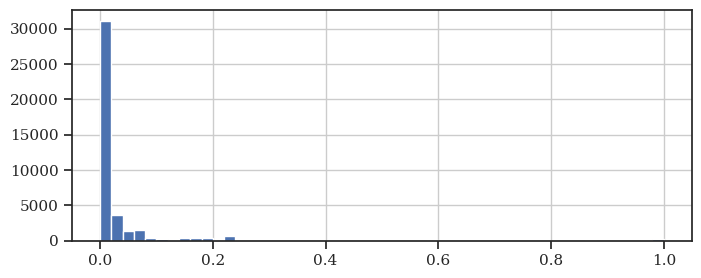

In [39]:
df["is_anchoring_learnt"] = anchoring_reg.predict(df_to_X(df)).clip(0, 1)
df["is_anchoring_learnt"].hist(bins=50)
pass

In [40]:
data_reg["is_anchoring"].value_counts(normalize=True)

is_anchoring
False    0.97038
True     0.02962
Name: proportion, dtype: float64

## Compute the ProMis landscapes for the ship categories

In [41]:
def landscape_for_mmsi(
    mmsi: int,
    where: CartesianCollection | np.ndarray | None = None,
    n_jobs: int = 16,
    return_time=False,
) -> CartesianCollection:
    # For simplicity, we extract the metadata of the first observation
    metadata = df[df["MMSI"] == mmsi].iloc[0]

    specific = copy(logic)

    # % Perception from sensors
    # draught ~ normal(3, 0.5).
    # 0.1::anchoring.
    # 0.9::travels_waterways.

    # % Background knowledge
    # sufficient_depth(X) :-
    #     A is depth(X, water), B is draught,
    #     A + B < -1.5, \+ over(X, land).

    # 0.95::safe(X) :-
    #     sufficient_depth(X), distance(X, land) > 50.

    # proper_anchorage(X) :-
    #     anchoring, over(X, anchorage);
    #     \+ anchoring, \+ over(X, anchorage).

    # 0.90::waterway_preference(X) :-
    #     travels_waterways, distance(X, waterway) < 400;
    #     \+ travels_waterways.

    # % Compliance with Constitution
    # landscape(X) :-
    #     proper_anchorage(X), safe(X),
    #     waterway_preference(X).

    vessel_type = metadata["VesselTypeName"].replace(" ", "_").lower()
    specific += f"\nis_{vessel_type}."
    for vessel_type in relevant_vessel_types:
        if vessel_type != metadata["VesselTypeName"]:
            # For clarity, we add a negative fact for all other vessel types
            specific += f"\n0.0::is_{vessel_type.lower().replace(' ', '_').replace(',', '_')}."

    # length = metadata["Length"]
    # if isfinite(length) and length > 0:
    #     specific += f"\nlength ~ normal({length}, {length * 0.05})."
    # else:
    #     # Some prior knowledge
    #     specific += "\nlength ~ normal(30, 10)."

    if metadata["travels_waterways"]:
        specific += "\n0.9::travels_waterways."
    else:
        specific += "\n0.1::travels_waterways."

    probability_is_anchoring = metadata["is_anchoring_learnt"]
    specific += f"\n{probability_is_anchoring}::anchoring."

    draught = metadata["Draft"]
    if isfinite(draught) and draught > 0:
        specific += f"\ndraught ~ normal({draught}, {abs(draught) * 0.1})."
    else:
        # Some prior knowledge
        specific += "\ndraught ~ normal(2, 1)."

    specific += "\n\n"  # Add newlines for better readability

    if where is None:
        specific_support = support
    else:
        if isinstance(where, np.ndarray):
            specific_support = CartesianCollection(origin=origin, number_of_values=0)
            specific_support.append_with_default(where, value=())
        else:
            specific_support = where

    before = monotonic()
    res = promis.solve(
        specific_support, specific, n_jobs=n_jobs, batch_size=10, show_progress=False
    )
    after = monotonic()

    if return_time:
        return res, after - before
    return res


landscapes = {
    "Cargo": landscape_for_mmsi(636017103),
    "Search and rescue vessels": landscape_for_mmsi(367531710),
    "Towing": landscape_for_mmsi(303461000),
}

In [42]:
time = []

the_support = CartesianRasterBand(origin, (10, 5), width, height)

for _ in range(5):
    _, diff = landscape_for_mmsi(636017103, where=the_support, n_jobs=None, return_time=True)
    time.append(diff)

np.mean(time).item(), np.std(time).item()

(1.1576210293918847, 0.8876974542513554)

### Save them for external use

In [43]:
for vessel_type, landscape in landscapes.items():
    # Store the landscape
    path = output_folder / "landscape"
    path.mkdir(exist_ok=True)
    landscape.to_polar().to_csv(path / f"{vessel_type}.csv")

    # Store the trace of the vessels
    df_ = df[df["VesselTypeName"] == vessel_type]
    path = output_folder / "ais-trace"
    path.mkdir(exist_ok=True)
    df_[["MMSI", "LAT", "LON"]].to_csv(path / f"{vessel_type}.csv", index=False)

### Visualize the landscapes

In [44]:
# This will be used much later
ship_marker = parse_path(svg2paths("ship-icon.svg")[1][0]["d"])
ship_marker.vertices -= ship_marker.vertices.mean(axis=0)
ship_marker = ship_marker.transformed(Affine2D().rotate_deg(180)).transformed(
    Affine2D().scale(-1, 1)
)

Lowered zoom level to keep map size reasonable. (z = 12)


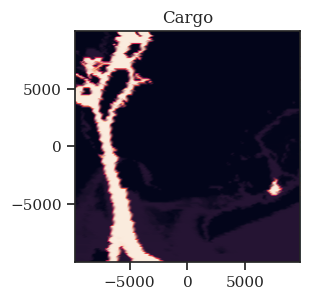

Lowered zoom level to keep map size reasonable. (z = 12)


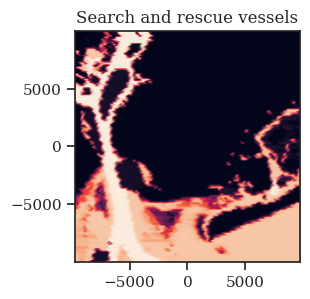

Lowered zoom level to keep map size reasonable. (z = 12)


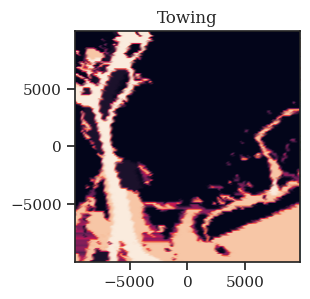

<Figure size 800x300 with 0 Axes>

In [45]:
for name, landscape in landscapes.items():
    landscape.scatter()
    plt.title(name)
    plt.show()
    plt.clf()

In [100]:
interpolators = {
    vessel_type: landscape.get_interpolator(method="nearest")
    for vessel_type, landscape in landscapes.items()
}

In [101]:
typical_ship_speed = 5  # meters per second
typical_sample_time = 60  # seconds

In [102]:
def plot_trajectories(all_positions: ndarray, label: str | None = "Trajectory {}", **kwargs):
    if len(all_positions.shape) == 2:
        all_positions = all_positions[None, ...]
    for i, positions in enumerate(all_positions):
        plt.plot(*zip(*positions), label=label.format(i) if label else None, **kwargs)

Lowered zoom level to keep map size reasonable. (z = 12)


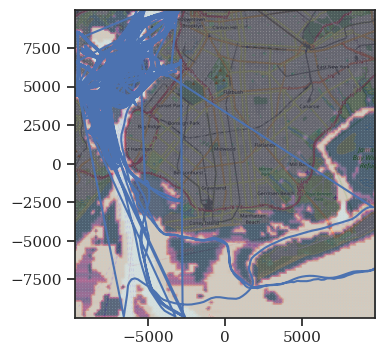

<Figure size 800x300 with 0 Axes>

In [103]:
plt.figure(figsize=(6, 4))
landscape.scatter(s=0.2, alpha=0.5)
positions = stack((df_["East"], df_["North"])).T
plot_trajectories(positions, label="True trajectory")
plt.show()
plt.clf()
pass

In [104]:
def plot_trajectories_animated(positions: ndarray, filename: str = "trajectory.gif") -> None:
    fig, _ = plt.subplots()
    landscape.scatter()
    (line,) = plt.plot(*zip(*positions.T), label="Ship Position")

    def update(num, x, y, line):
        line.set_data(x[:num], y[:num])
        line.axes.axis([-width / 2, width / 2, -height / 2, height / 2])
        return (line,)

    ani = FuncAnimation(
        fig,
        update,
        len(positions),
        fargs=[positions[:, 0], positions[:, 1], line],
        interval=1000 / 60,
        blit=True,
    )
    ani.save(filename)
    plt.clf()


# plot_trajectories_animated(positions)

## Implement CoFi using a particle filter

We directly define the experiments that we will run.

In [ ]:
def run_experiment_pf1(
    ship_df: pd.DataFrame,
    seed_value: int = 2024,
    constitutional_trust: float = 0.8,
    interpolator: Any | None = None,
) -> pd.DataFrame:
    def create_initial_particles(N: int) -> ndarray:
        return np.stack(
            [
                uniform(loc=-width / 2, scale=width).rvs(N),  # x position (east)
                uniform(loc=-height / 2, scale=height).rvs(N),  # y position (north)
                uniform(loc=0, scale=2 * pi).rvs(N),  # heading
                norm(loc=5, scale=3).rvs(N),  # speed
                # norm(loc=0, scale=typical_ship_speed).rvs(N),
                # norm(loc=0, scale=typical_ship_speed).rvs(N),
            ]
        ).T

    def predict(particles, dt=1.0):
        """move according to control input u (heading change, velocity)
        with noise Q (std heading change, std velocity)`"""

        particles = particles.copy()

        N = len(particles)

        # We first add noise
        # noise = standard_normal(N) * std[1]
        # particles[:, [0, 1]] += particles[:, [2, 3]] * dt + noise
        particles[:, 2] += standard_normal(N) * 0.05
        particles[:, 2] %= 2 * pi

        particles[:, 3] += standard_normal(N) * 0.3

        distance = particles[:, 3] * dt  # + (standard_normal(N) * std)

        # TODO: possibly also add noise to the heading
        particles[:, 0] += np.cos(particles[:, 2]) * distance
        particles[:, 1] += np.sin(particles[:, 2]) * distance

        return particles

    def update(
        particles,
        weights,
        z,
        R,
        constitutional_trust: float = constitutional_trust,
    ):
        weights = weights.copy()

        positions = particles[:, :2]
        distance = np.linalg.norm(positions - z, axis=1)

        # Evaluate and RBF kernel
        weights *= np.exp(-(distance**2) / (2 * R**2))

        if constitutional_trust > 0:
            # if landscape is None:
            #     # take a random subset of positions
            #     sampled_positions = positions[np.random.choice(len(positions), 100, replace=False)]
            #     this_landscape = landscape_for_mmsi(
            #         ship_df["MMSI"].iloc[0], where=sampled_positions, n_jobs=None
            #     )
            #     this_interpolator.get_interpolator()
            # else:
            #     this_interpolator = interpolator
            this_interpolator = interpolator
            constitution = this_interpolator(positions)[:, 0]
            weights *= constitutional_trust * constitution + (1 - constitutional_trust)

        weights += 1.0e-300  # avoid round-off to zero
        weights /= sum(weights)  # normalize

        return weights

    def estimate(particles, weights):
        """returns mean and variance of the weighted particles"""

        mean = np.average(particles, weights=weights, axis=0)
        var = np.average((particles - mean) ** 2, weights=weights, axis=0)
        return mean, var

    def neff(weights):
        return 1.0 / np.sum(np.square(weights))

    def resample_from_index(particles, weights, indexes):
        particles[:] = particles[indexes]
        weights.resize(len(particles))
        weights.fill(1.0 / len(weights))

    def run_pf1(
        N: int,
        data: np.ndarray,
        sensor_std_err=5000,
        do_plot=False,
        plot_particles=False,
    ):
        if do_plot:
            plt.figure()

        # Create particles uniformly over the entire space
        particles = create_initial_particles(N)

        # However, for the location we can do a bit better by assuming that the current
        # observation is approximately correct
        particles[:, 0] = norm(loc=data[0, 0], scale=10).rvs(N)
        particles[:, 1] = norm(loc=data[0, 1], scale=10).rvs(N)

        # create weights
        weights = np.ones(N) / N

        if do_plot and plot_particles:
            alpha = 0.20
            if N > 5000:
                alpha *= np.sqrt(5000) / np.sqrt(N)
            plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color="g")

        weights_trace = []
        particle_trace = []
        xs = []
        for i, obs in enumerate(data):
            # move
            particles = predict(particles, dt=obs[4])

            # incorporate measurements
            weights = update(particles, weights, z=obs[:2], R=sensor_std_err)

            # resample if too few effective particles
            if neff(weights) < N / 2:
                indexes = systematic_resample(weights)
                resample_from_index(particles, weights, indexes)
                assert np.allclose(weights, 1 / N)
            mu, var = estimate(particles, weights)
            xs.append(mu)

            weights_trace.append(weights.copy())
            particle_trace.append(particles.copy())

            if do_plot:
                if plot_particles:
                    plt.scatter(
                        particles[:, 0], particles[:, 1], color="k", marker=",", s=0.5, alpha=0.2
                    )
                p1 = plt.scatter(obs[0], obs[1], marker="x", color="r")
                p2 = plt.scatter(mu[0], mu[1], marker="s", color="b")

            # print(f"Step {i+1}/{len(data)}")

        xs = np.array(xs)
        # plt.plot(xs[:, 0], xs[:, 1])
        if do_plot:
            plt.legend([p1, p2], ["Actual", "PF"], loc=4, numpoints=1)
        # plt.xlim(-width / 2, width / 2)
        # plt.ylim(-height / 2, height / 2)

        pos_error = np.linalg.norm(mu[:2] - data[:, :2], axis=1)
        # print("error, variance: ", pos_error.mean(), pos_error.var())
        all_error = np.linalg.norm(xs[:, :] - data[:, :4], axis=1)
        # print("all error, variance: ", all_error.mean(), all_error.var())

        if do_plot:
            plt.show()

        return {
            "particles": array(particle_trace),
            "weights": array(weights_trace),
            "estimates": xs,
            "pos_error": pos_error,
            "pos_error_mean": pos_error.mean(),
            "all_error": all_error,
            "all_error_mean": all_error.mean(),
            "truth": data,
        }

    ship_df = ship_df.copy()
    ship_df.loc[:, "RelativeTime"] = (
        ship_df["BaseDateTime"] - ship_df["BaseDateTime"].iloc[0]
    ).dt.total_seconds()
    assert ship_df["RelativeTime"].is_monotonic_increasing

    ground_truth = stack(
        (
            ship_df["East"],
            ship_df["North"],
            deg2rad(ship_df["COG"]),
            ship_df["SOG"],
            ship_df["RelativeTime"],
        )
    ).T

    ground_truth[0, 4] = 0
    ground_truth[1:, 4] = ground_truth[1:, 4] - ground_truth[:-1, 4]

    seed(seed_value)
    return run_pf1(N=2000, data=ground_truth, plot_particles=True)


res_specific = run_experiment_pf1(
    df[df["MMSI"] == track_mmsi],
    seed_value=2024,
    interpolator=interpolators["Cargo"],
)
# res_specific

In [106]:
relevant_MMSIs

Index([366952890, 367000140, 367000120, 368217570, 367549870, 367000150,
       338533000, 367078250, 368091960, 367000110,
       ...
       367597640, 563050400, 367428270, 372148000, 368029640, 636092678,
       367779250, 636017103, 538001663, 367191410],
      dtype='int64', name='MMSI', length=149)

In [129]:
results = []

df_for_type = df[df["VesselTypeName"].isin(landscapes.keys())]
df_for_type = df_for_type[df_for_type["MMSI"].isin(relevant_MMSIs)]

for tau in np.arange(0.0, 1.1, 0.1):
    for mmsi in relevant_MMSIs[:100]:
        data = df_for_type[df_for_type["MMSI"] == mmsi].copy()
        if data.empty:
            continue

        vessel_type = data["VesselTypeName"].iloc[0]

        experiment_result = run_experiment_pf1(
            data,
            constitutional_trust=tau,
            seed_value=2024,
            # landscape=landscape_for_mmsi(
            #     mmsi, where=CartesianRasterBand(origin, (50, 50), width, height)
            # ),
            interpolator=interpolators[vessel_type],
        )
        results.append(
            dict(
                mmsi=mmsi,
                type=vessel_type,
                tau=tau,
                seed=2024,
                **experiment_result,
            )
        )
        print(
            f"Finished {mmsi} (progress: {len(results)}/{len(df_for_type['MMSI'].unique()) * 11})"
        )

df_results = pd.DataFrame(results)
df_results

Finished 338533000 (progress: 1/583)
Finished 367078250 (progress: 2/583)
Finished 367015880 (progress: 3/583)
Finished 368111580 (progress: 4/583)
Finished 367078850 (progress: 5/583)
Finished 369131000 (progress: 6/583)
Finished 367367390 (progress: 7/583)
Finished 303461000 (progress: 8/583)
Finished 366902120 (progress: 9/583)
Finished 366993880 (progress: 10/583)
Finished 367497610 (progress: 11/583)
Finished 367796040 (progress: 12/583)
Finished 367754450 (progress: 13/583)
Finished 367707930 (progress: 14/583)
Finished 367179990 (progress: 15/583)
Finished 367304530 (progress: 16/583)
Finished 367516950 (progress: 17/583)
Finished 367586910 (progress: 18/583)
Finished 367614410 (progress: 19/583)
Finished 367073820 (progress: 20/583)
Finished 366769330 (progress: 21/583)
Finished 367341190 (progress: 22/583)
Finished 367682610 (progress: 23/583)
Finished 366516370 (progress: 24/583)
Finished 366993970 (progress: 25/583)
Finished 367419080 (progress: 26/583)
Finished 366939790 (p

,mmsi,type,tau,seed,particles,weights,estimates,pos_error,pos_error_mean,all_error,all_error_mean,truth
0,338533000,Towing,0.0,2024,"[[[-3615.226979284329, 7026.491069274527, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[-4313.881695757326, 6133.951869498181, 3.141...","[25.873373359068513, 25.873373359068513, 25.30...",2890.424642,"[17.575854521776712, 18.079696742618065, 27.05...",289.437964,"[[-4309.139974887753, 6149.916229371825, 5.342..."
1,367078250,Towing,0.0,2024,"[[[-8967.026155500193, 5696.727483132134, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[-9665.680871973194, 4804.188283355786, 3.141...","[2351.8536140781353, 2066.6278431756236, 1789....",2829.252152,"[17.129295639788133, 272.7074535180284, 512.51...",385.949543,"[[-9660.939151103616, 4820.15264322943, 1.0681..."
2,367015880,Towing,0.0,2024,"[[[-8892.64213215062, 5664.427486925806, 1.383...","[[0.0005072512056533528, 0.0005026256090089099...","[[-9591.296848623602, 4771.888287149461, 3.141...","[1340.9615844951613, 1268.416609981096, 1219.6...",2306.062337,"[16.770506189741816, 151.4554889364029, 304.51...",637.387894,"[[-9586.555127754043, 4787.852647023104, 1.169..."
3,368111580,Search and rescue vessels,0.0,2024,"[[[3289.754472489906, -2315.548718873406, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[2591.099756016906, -3208.0879186497496, 3.14...","[1063.6923950227094, 1063.451107443954, 1064.0...",2486.440346,"[17.7182742986195, 16.75469932641871, 29.62579...",1556.687911,"[[2595.8414768864827, -3192.123558776109, 6.28..."
4,367078850,Towing,0.0,2024,"[[[-2169.1019173372424, 7445.553115740551, 1.3...","[[0.0005072512056533528, 0.0005026256090089099...","[[-2867.756633810242, 6553.013915964217, 3.141...","[398.09517447369103, 397.2388055662963, 396.39...",1698.274019,"[17.54317010195231, 34.9822393861334, 66.11801...",644.629640,"[[-2863.014912940666, 6568.978275837849, 1.218..."
...,...,...,...,...,...,...,...,...,...,...,...,...
413,367599210,Towing,1.0,2024,"[[[-8747.889485471185, 5766.405966438018, 1.38...","[[0.0007139469683363345, 0.0007323809034558114...","[[-9379.929772691965, 4993.357216207672, 3.132...","[4587.95666433334, 4262.981961865755, 3977.407...",2465.115278,"[120.6949928533817, 242.8974302828792, 528.208...",2034.400295,"[[-9441.802481074608, 4889.831126535315, 1.096..."
414,367064470,Towing,1.0,2024,"[[[-8382.348131493605, 3835.94966296965, 1.383...","[[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...","[[-8491.925198903577, 3400.1679942046067, 3.09...","[1765.9909548051373, 1763.9753765460623, 1765....",2435.447192,"[731.9668771312582, 951.0268805732184, 1130.38...",1790.553189,"[[-9076.261127097028, 2959.374823066947, 4.227..."
415,338871000,Towing,1.0,2024,"[[[10310.588094143059, -1945.568497860626, 1.3...","[[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00...","[[9451.121971081953, -2881.5659116007437, 3.10...","[18271.036563178164, 18046.701063085755, 17814...",10146.872254,"[175.91193489203204, 215.3980274834082, 294.93...",4362.952907,"[[9616.675098539636, -2822.143337763329, 4.852..."
416,636091125,Cargo,1.0,2024,"[[[-2033.0304592008354, -8917.143060851191, 1....","[[7.609718024665454e-05, 0.000754032541254793,...","[[-2979.7103573037602, -10098.303490831795, 3....","[19270.771877900792, 19022.62228131002, 18787....",5523.441752,"[395.90235083830447, 584.2490514878526, 917.64...",1662.426697,"[[-2726.943454804259, -9793.717900753894, 5.18..."


In [131]:
# before = monotonic()
# run_experiment_pf1(
#     data[:20],
#     constitutional_trust=0.5,
#     seed_value=2024,
#     interpolator=interpolator,
#     full_inference=False,
#     use_constitution=True,
# )
# after = monotonic()
# after - before

In [132]:
df_results.to_pickle("res-all-taus.pkl")

In [133]:
df_results = pd.read_pickle("res-all-taus-examples-specific-landscape.pkl")

<Axes: >

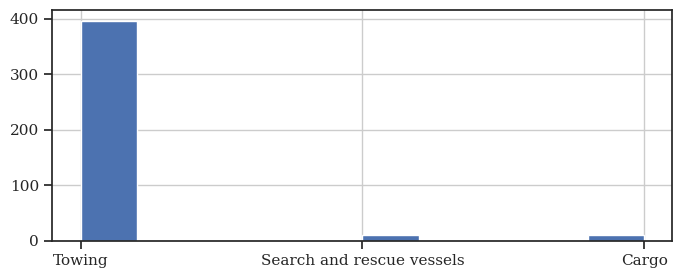

In [134]:
df_results["type"].hist()

In [198]:
# For identifying interesting cases
with_benefit = with_benefit_strong = df_results[
    (df_results["tau"] > 0.4) | (df_results["tau"] == 0.0)
]

with_benefit = with_benefit.groupby("mmsi").apply(
    lambda group: group.copy()[
        (group["tau"] == 0.0)
        | (group["pos_error_mean"] == group[group["tau"] != 0.0]["pos_error_mean"].min())
    ]
    .assign(
        benefit=(
            group[group["tau"] != 0.0]["pos_error_mean"].min()
            - group[group["tau"] == 0.0]["pos_error_mean"].item()
        )
    )
    .sort_values("tau"),
    include_groups=False,
)

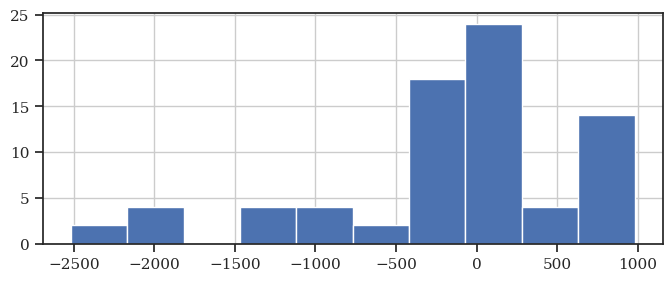

In [199]:
with_benefit["benefit"].hist()
pass

In [227]:
with_benefit_strong = with_benefit[with_benefit["benefit"] > 0]
with_benefit_strong = with_benefit_strong[
    with_benefit_strong["benefit"] > with_benefit_strong["benefit"].quantile(0.5)
]
results_mmsis = with_benefit_strong.index.get_level_values(0).unique()
len(results_mmsis)

10

In [232]:
results = with_benefit_strong.loc[results_mmsis[4]].sort_values("tau")
f"mmis: {results_mmsis[0]} @ tau: {results['tau'].iloc[1]}"

'mmis: 366902120 @ tau: 0.5'

In [233]:
result_pf, result_cofi = results.iloc[0], results.iloc[1]

In [234]:
# fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# columns = ["x", "y", "d_phi", "d_r"]

# result = result_cofi

# for i, ax in enumerate(axes.flatten()):
#     if i >= result["particles"].shape[2]:
#         break
#     ax.plot(result["particles"][:, :, i], alpha=0.2)

#     if i < result_pf["estimates"].shape[1]:
#         ax.plot(result_pf["estimates"][:, i], c="black", lw=2, label="Mean_pf")
#     if i < result_cofi["estimates"].shape[1]:
#         ax.plot(result_cofi["estimates"][:, i], c="black", lw=2, label="Mean_cofi")

#     if i < result["truth"].shape[1]:
#         ax.plot(result["truth"][:, i], c="green", lw=2, label="Ground Truth")
#     ax.set_title(columns[i])

#     # ax.axvline(result["deviate_from"], c="black", ls="--", lw=1)

#     if i == 0:
#         ax.set_ylim(-width, width)
#     if i == 1:
#         ax.set_ylim(-height, height)

#     if i == 0:
#         ax.legend()

# axes[1, 0].axhline(2 * pi, c="black", ls="--", lw=1)

# plt.tight_layout()
# plt.show()
# plt.clf()

Lowered zoom level to keep map size reasonable. (z = 12)


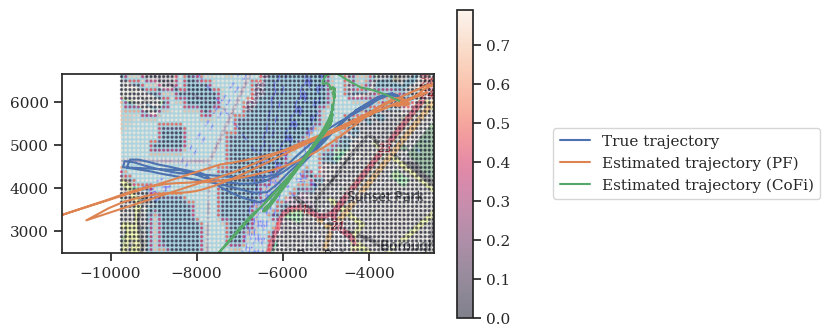

In [235]:
plt.figure(figsize=(6, 4))
bg = landscape.scatter(s=2, alpha=0.5)
plot_trajectories(result_pf["truth"][:, :2], label="True trajectory")
plot_trajectories(result_pf["estimates"][:, :2], label="Estimated trajectory (PF)")
plot_trajectories(result_cofi["estimates"][:, :2], label="Estimated trajectory (CoFi)")

# show_n_particles = 10
# plot_trajectories(trace_all_particles[:, :show_n_particles, :2].swapaxes(1, 0), label=None)

scale = 1.5
# plt.gca().set_xlim(-width / 2 * scale, width / 2 * scale)
# plt.gca().set_ylim(-height / 2 * scale, height / 2 * scale)

# plt.gca().set_xlim(-15_000, -2_000)
# plt.gca().set_ylim(8_000, 18_000)

all_coords = np.concatenate(
    [result_pf["truth"][:, :2], result_pf["estimates"][:, :2], result_cofi["estimates"][:, :2]]
)
plt.gca().set_xlim(all_coords[:, 0].min(), all_coords[:, 0].max())
plt.gca().set_ylim(all_coords[:, 1].min(), all_coords[:, 1].max())

# Move legend to the right of the plot
plt.legend()
move_legend(plt.gca(), loc="center left", bbox_to_anchor=(1.3, 0.5))

plt.colorbar(bg)
pass

### Visualize using Kepler.gl

In [ ]:
def cartesian_to_polar(coords: ndarray) -> ndarray:
    collection = CartesianCollection(origin=origin, number_of_values=1)
    collection.append_with_default(coords, np.nan)
    return collection.to_polar().coordinates()


def make_line_string(cartesian_coords: ndarray) -> str:
    return json.dumps(
        {
            "type": "LineString",
            "coordinates": cartesian_to_polar(cartesian_coords).tolist(),
        }
    )


start_date = "2023-08-01 0:0:00"
date_format = "%Y-%m-%d %X"


def make_route_points(cartesian_coords: ndarray) -> str:
    """

    Args:
        cartesian_coords: Shape (T, 2)
    """
    return json.dumps(
        {
            "type": "FeatureCollection",
            "features": [
                {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": coord.tolist(),
                    },
                    "properties": {
                        "timestamp": time,
                    },
                }
                for coord, time in zip(
                    cartesian_to_polar(cartesian_coords),
                    pd.date_range(start=start_date, periods=cartesian_coords.shape[0]).strftime(
                        date_format
                    ),
                )
            ],
        }
    )


def make_particles(cartesian_coords: ndarray, weights: ndarray) -> str:
    """

    Args:
        cartesian_coords: Shape (T, N, 2)
        weights: Shape (T, N)
    """
    return json.dumps(
        {
            "type": "FeatureCollection",
            "features": [
                {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": coord.tolist(),
                    },
                    "properties": {
                        "timestamp": time,
                        "weight": weight,
                    },
                }
                for coords_t, weights_t, time in zip(
                    cartesian_coords,
                    weights,
                    pd.date_range(start=start_date, periods=cartesian_coords.shape[0]).strftime(
                        date_format
                    ),
                )
                for coord, weight in zip(
                    cartesian_to_polar(coords_t),
                    weights_t.tolist(),
                )
            ],
        }
    )

In [ ]:
subsample_particles = 4
map = KeplerGl(
    data={
        "True Trajectory Track": make_line_string(result_pf["truth"][:, :2]),
        "True Trajectory": make_route_points(result_pf["truth"][:, :2]),
        #
        "Estimated Trajectory (CoFi) Track": make_line_string(result_cofi["estimates"][:, :2]),
        "Estimated Trajectory (CoFi)": make_route_points(result_cofi["estimates"][:, :2]),
        #
        "Estimated Trajectory (PF) Track": make_line_string(result_pf["estimates"][:, :2]),
        "Estimated Trajectory (PF)": make_route_points(result_pf["estimates"][:, :2]),
        #
        "Particles (PF)": make_particles(
            result_pf["particles"][:, :subsample_particles, :2],
            weights=result_pf["weights"][:, :subsample_particles],
        ),
        "Particles (CoFi)": make_particles(
            result_cofi["particles"][:, :subsample_particles, :2],
            weights=result_cofi["weights"][:, :subsample_particles],
        ),
    },
    config={
        "version": "v1",
        "config": {
            "mapState": {
                "latitude": cartesian_to_polar(all_coords)[:, 1].mean(),
                "longitude": cartesian_to_polar(all_coords)[:, 0].mean(),
                "zoom": 11,
            },
            "visState": {
                "filters": [
                    {
                        "dataId": [data_field],
                        "id": f"94q7ipgwi-{data_field}",
                        "name": ["timestamp"],
                        "type": "DateTime",
                        "yAxis": None,
                        "speed": 0.2,
                    }
                    for data_field in [
                        "True Trajectory",
                        "Estimated Trajectory (CoFi)",
                        "Estimated Trajectory (PF)",
                        "Particles (PF)",
                        "Particles (CoFi)",
                    ]
                ]
            },
        },
    },
)
# map.save_to_html(file_name="debug_keplergl.html")
map

You can now invoke `show-html.py` to serve the HTML file.

### Visualize the results with matplotlib

In [ ]:
res_ = []
for vessel_type in interpolators:
    df_ = df[df["VesselTypeName"] == vessel_type]
    points = df_[["East", "North"]].values
    c = interpolators[vessel_type](points)
    for value in c:
        res_.append(
            {
                "Vessel Type": vessel_type,
                "Constitutional": value.item(),
            }
        )

res_df = pd.DataFrame(res_)
res_df

In [ ]:
sns.barplot(
    data=res_df.replace({"Vessel Type": {"Search and rescue vessels": "SAR"}}),
    x="Vessel Type",
    y="Constitutional",
    hue="Vessel Type",
    order=["Cargo", "Towing", "SAR"],
    hue_order=["Cargo", "Towing", "SAR"],
)
sns.despine()
plt.ylabel(r"Average $P(c_t | \mathbf{x}_t, \mathbf{z}_t)$")
plt.xlabel("")
plt.ylim(0, 1)
plot_put = output_folder / "plots"
plot_put.mkdir(exist_ok=True)
plt.savefig(plot_put / "ais-constitution.pdf", bbox_inches="tight")
pass

In [ ]:
# df_results.head()

In [ ]:
df_results_export = df_results.copy()[
    ["mmsi", "type", "tau", "seed", "pos_error_mean", "all_error_mean"]
]
df_results_export.to_csv(output_folder / "res-all-taus.csv", index=False)

df_ = df_results_export.rename(
    columns={
        "type": "Vessel Type",
        "tau": r"$\tau$",
        "pos_error_mean": "Relative Position Error",
    }
)
df_ = df_[df_["Relative Position Error"] < 100_000]
reference_error = df_[(df_["Vessel Type"] == "Cargo") & (df_[r"$\tau$"] == 0.0)][
    "Relative Position Error"
].mean()
df_["Relative Position Error"] /= reference_error
sns.barplot(
    x=r"$\tau$",
    y="Relative Position Error",
    hue="Vessel Type",
    data=df_[df_[r"$\tau$"].isin([0.0, 0.5, 1.0])],
    hue_order=["Cargo", "Towing", "Search and rescue vessels"],
)

# move the legend outside
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))

sns.despine()

plt.savefig(plot_put / "relative_position_error.pdf", bbox_inches="tight")
pass

In [ ]:
type_wise_data = []

for type in df_["Vessel Type"].unique():
    type_data = df_[df_["Vessel Type"] == type].copy()
    type_data["Relative Position Error"] /= type_data["Relative Position Error"][
        type_data[r"$\tau$"] == 0
    ].mean()
    type_wise_data.append(type_data)

normalized_data = pd.concat(type_wise_data)

In [ ]:
sns.lineplot(
    x=r"$\tau$",
    y="Relative Position Error",
    hue="Vessel Type",
    data=normalized_data.replace(
        {
            "Vessel Type": {
                "Search and rescue vessels": "Uncompliant (SAR)",
                "Cargo": "Compliant (Cargo)",
                "Towing": "Somewhat Compliant (Towing)",
            }
        }
    ),
)
plt.axhline(1, c="black", ls="--", lw=1)
plt.xlim(0, 1)
sns.despine()
pass

In [ ]:
# # sns.barplot(x="tau", y="all_error_mean", hue="type", data=df_results)
# df_rel = df_.copy()
# # Divide the error by the reference error for each Vessel Type @ tau = 0
# df_rel["Relative Position Error"] = (
#     # TODO why is this odd?
#     df_rel.groupby("Vessel Type")
#     .apply(
#         lambda x: x["Relative Position Error"]
#         / x[x[r"$\tau$"] == 0]["Relative Position Error"].mean(),
#         include_groups=False,
#     )
#     .reset_index()["Relative Position Error"]
# )
# sns.lineplot(
#     x=r"$\tau$",
#     y="Relative Position Error",
#     hue="Vessel Type",
#     data=df_rel,
# )
# sns.despine()
# plt.xlim(0, 1)
# sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))
# pass

In [ ]:
sns.barplot(x="tau", y="pos_error_mean", hue="type", data=df_results)
plt.ylim(None, 30_000)

In [ ]:
# Groub by MMSI and trhen take the tau with the lowest error each
# df_results[["mmsi", "pos_error_mean"]].groupby("mmsi").apply(
#     lambda x: x.sort_values("tau").loc[x["pos_error_mean"].idxmin()]
# )
res = []
for mmis in df_results["mmsi"].unique():
    df_ = df_results[df_results["mmsi"] == mmis]
    # sort by tau
    df_ = df_.sort_values("pos_error_mean")
    res.append((df_["type"].iloc[0], df_["tau"].iloc[0]))

res = pd.DataFrame(res, columns=["Vessel Type", r"$\tau$"])
# Rname Search and rescue vessels to SAR
res["Vessel Type"] = res["Vessel Type"].replace("Search and rescue vessels", "SAR")
res

In [ ]:
r_ = res.copy()

# r_["Vessel Type"] = "All"
# res_ = pd.concat([res, r_], axis=0)
# res_.sort_values("Vessel Type", inplace=True)

sns.histplot(
    r_,
    x=r"$\tau$",
    hue="Vessel Type",
    multiple="stack",
    bins=10,
    stat="percent",
    shrink=0.75,
    # palette="colorblind",
)

plt.ylabel("")
plt.yticks(plt.yticks()[0], [f"{i.get_text()}%" for i in plt.yticks()[1]])
sns.despine()

# Fix the placmenet of the x-axis
plt.xticks(np.arange(0, 1.1, 0.1) + 0.05, [f"{i:.1f}" for i in np.arange(0, 1.1, 0.1)])

plt.savefig(Path(".") / "plots" / "tau-distribution.pdf", bbox_inches="tight")

pass

In [ ]:
sns.displot(
    df_results,
    x="pos_error_mean",  # or "all_error"
    col="tau",
    col_wrap=3,
    facet_kws=dict(margin_titles=True),
)

## Older stuff

In [ ]:
results = []

df_for_type = df[df["VesselTypeName"].isin(["Cargo", "Cargo hazardous"])]

for tau in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    for mmsi in relevant_MMSIs:
        for seed_value in [2024]:
            data = df_for_type[df_for_type["MMSI"] == mmsi].copy()
            if data.empty:
                continue
            vessel_type = data["VesselTypeName"].iloc[0]
            experiment_result = run_experiment(
                data, constitutional_trust=tau, seed_value=seed_value, verbose=False
            )
            results.append(
                dict(
                    mmsi=mmsi,
                    type=vessel_type,
                    tau=tau,
                    seed=seed_value,
                    mean_mean=np.mean(experiment_result["position_accuracy_mean"]),
                    mean_std=np.std(experiment_result["position_accuracy_mean"]),
                    map_mean=np.mean(experiment_result["position_accuracy_map"]),
                    map_std=np.std(experiment_result["position_accuracy_map"]),
                    **experiment_result,
                )
            )
            print(f"Finished {mmsi} (progress: {len(results)}/{len(df_for_type['MMSI'].unique())})")

df_results = pd.DataFrame(results)
df_results

In [ ]:
sns.displot(
    df_results,
    x="mean_mean",
    col="tau",
    col_wrap=3,
    facet_kws=dict(margin_titles=True),
)

In [ ]:
g = sns.catplot(
    data=df_results,
    kind="bar",
    x="tau",
    y="mean_mean",
    errorbar="sd",
    alpha=0.6,
    height=6,
)

In [ ]:
# Visualize the weights of the particles
plt.plot(result["trace_weights_unnormalized"])
pass

In [ ]:
plt.plot(np.diff(result["trace_time"]) / 60)
pass

In [ ]:
# plt.hist(trace_all_particles[20, :, 2].ravel(), bins=100)
# pass

In [ ]:
plt.figure(figsize=(6, 4))
landscape.scatter(s=0.1, alpha=0.5)
plot_trajectories(result["ground_truth"], label="True trajectory")
plot_trajectories(result["trace_state"][:, :2], label="Estimated trajectory")

# show_n_particles = 10
# plot_trajectories(trace_all_particles[:, :show_n_particles, :2].swapaxes(1, 0), label=None)

scale = 1.5
plt.gca().set_xlim(-width / 2 * scale, width / 2 * scale)
plt.gca().set_ylim(-height / 2 * scale, height / 2 * scale)

plt.colorbar()
plt.legend()
pass

In [ ]:
plt.figure(figsize=(6, 4))
plt.gca().set_aspect("equal")
landscape.scatter(s=0.1, alpha=0.2)
# plt.scatter(*result["trace_all_particles"][:, :, :2][50, ...].T, c="r", s=1)
plt.scatter(*debug_df[["East", "North"]].values.T, c="r", s=1)
plt.xlim(-width / 2 * scale, width / 2 * scale)
plt.ylim(-height / 2 * scale, height / 2 * scale)

pass

In [ ]:
index = 30

plt.gca().set_aspect("equal")

# draw a box around the observed frame
plt.plot(
    [-width / 2, width / 2, width / 2, -width / 2, -width / 2],
    [-height / 2, -height / 2, height / 2, height / 2, -height / 2],
    "k-",
    alpha=0.3,
    label="Frame",
)

plot_trajectories(result["ground_truth"], label="True trajectory", color="k", alpha=0.3)

plt.hist2d(
    *result["trace_all_particles"][index, :, :2].T,
    bins=50,
    range=[[-width / 2 * scale, width / 2 * scale], [-height / 2 * scale, height / 2 * scale]],
    cmap="Oranges",
)

if index > 0:
    # Plot the ship position and position estimate at that time point
    plt.gca().plot(
        *result["ground_truth"][index - 1],
        marker=ship_marker,
        markersize=14,
        label="True position",
        c="k",
        alpha=0.5,
    )
    plt.gca().plot(
        *result["trace_state"][index - 1, :2],
        marker=ship_marker,
        markersize=14,
        label="Estimated position",
        c="b",
    )


plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
pass

In [ ]:
res_starmap = pd.DataFrame(
    [
        dict(name=r"StarMap ($100 \times x 100$)", time=640.4149391481187),
        dict(name=r"StarMap ($100 \times x 100$)", time=627.0258562378585),
        dict(name=r"StarMap ($100 \times x 100$)", time=624.6253640819341),
        #
        dict(name=r"StarMap ($50 \times 50$)", time=495.63382973195985),
        dict(name=r"StarMap ($50 \times 50$)", time=487.28305474994704),
        dict(name=r"StarMap ($50 \times 50$)", time=487.8447328049224),
    ]
)
res_perf = pd.DataFrame(
    [
        dict(name="Particle Filter", time=0.03765651909634471 / 20),
        dict(name="Particle Filter", time=0.0383494570851326 / 20),
        dict(name="Particle Filter", time=0.03719700896181166 / 20),
        #
        dict(name="CoFi", time=113.63170561008155 / 20),
        dict(name="CoFi", time=113.54428059794009 / 20),
        dict(name="CoFi", time=113.22225885814987 / 20),
        #
        dict(name="CoFi Precomputed", time=0.051308222813531756 / 20),
        dict(name="CoFi Precomputed", time=0.04675357579253614 / 20),
        dict(name="CoFi Precomputed", time=0.05256968503817916 / 20),
    ]
)
cocktail = pd.DataFrame(
    [
        dict(name=r"StarMap ($100 \times 100$)", time=640.4149391481187),
        dict(name=r"StarMap ($100 \times 100$)", time=627.0258562378585),
        dict(name=r"StarMap ($100 \times 100$)", time=624.6253640819341),
        #
        dict(name=r"StarMap ($50 \times 50$)", time=495.63382973195985),
        dict(name=r"StarMap ($50 \times 50$)", time=487.28305474994704),
        dict(name=r"StarMap ($50 \times 50$)", time=487.8447328049224),
        #
        dict(name="CoFi\n10 iterations", time=113.63170561008155 / 20 * 10),
        dict(name="CoFi\n10 iterations", time=113.54428059794009 / 20 * 10),
        dict(name="CoFi\n10 iterations", time=113.22225885814987 / 20 * 10),
    ]
)
cocktail

In [ ]:
sns.barplot(data=cocktail, x="name", y="time", hue="name", palette="colorblind")
plt.xlabel("")
sns.despine()